In [13]:
import gzip
from collections import defaultdict

def readGz(f):
    for l in gzip.open(f):
        yield eval(l)

# Visit Prediction


## Question1:
Although we have built a validation set, it only consists of positive samples. For this task we also need
examples of user/business pairs that weren’t visited. Build such a set by randomly sampling users and
businesses until you have 100,000 non-visited user/business pairs. This random sample combined with
your 100,000 validation reviews now corresponds to the complete validation set for the visit prediction
task. Evaluate the performance (accuracy) of the baseline model on the validation set you have built 

## Method1: When we are preserving Bias in data

In [2]:
users =[]
business = []
total = set()
for l in readGz("train.json.gz"):
    a = (l['userID'],l['businessID'])
    total.add(a)
    users += [l['userID']]
    business += [l['businessID']]

In [3]:
data =[]
for l in readGz("train.json.gz"):
    data += [[l['userID'],l['businessID'],1]]

In [4]:
from random import shuffle
shuffle(users)
shuffle(business)

In [5]:
def check(user, business):
    if (user, business) in total:
            return False
    return True

In [6]:
from random import randint
j =0
negative = set()

while (j < 100000):
    x = randint(0, len(users)-1)
    y = randint(0, len(business)-1)
    if(check(users[x], business[y])) and (users[x], business[y]) not in negative:
            a= (users[x], business[y])
            negative.add(a)
            j = j+1

train = data[:len(data)/2]
valid = data[len(data)/2:]

new_n =[]
for l in negative:
    new_n += [list(l)]
for l in new_n:
    l.extend([0])

valid += new_n

In [7]:
import pickle

pickle.dump(valid, open("valid_data","wb"))

In [9]:
businessCount = defaultdict(int)
totalPurchases = 0

for l in train:
    user,business = l[0],l[1]
    businessCount[business] += 1
    totalPurchases += 1

mostPopular = [(businessCount[x], x) for x in businessCount]
mostPopular.sort()
mostPopular.reverse()


In [10]:
return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalPurchases*0.5: break

In [11]:
true =0
false =0
for l in valid:
    u,i,check = l[0], l[1], l[2]
    if i in return1 and check ==1:
        true = true+1
    if i not in return1 and check ==0:
        false = false+1

In [12]:
accuracy = 100.0*(true+false)/len(valid)
print ("%Accuracy on validation: " + str(accuracy))

%Accuracy on validation: 48.656


## Method2: When we are not preserving Bias in data

In [8]:
user = []
busi = []

for d in readGz("train.json.gz"):
    if d['userID'] not in user:
        user.append(d['userID'])
        
    if d['businessID'] not in busi:
        busi.append(d['businessID'])

In [9]:
def check(user, business):
    if (user, business) in total:
            return False
    return True

In [10]:
from random import randint
negative_1 =set()
k =0
while(k<50000):
    x = randint(0, len(user)-1)
    y = randint(0, len(busi)-1)
    if check(user[x], busi[y]) and (user[x], busi[y]) not in negative_1:
            a= (user[x], busi[y])
            negative_1.add(a)
            k = k+1

In [11]:
new_n_1 =[]
for l in negative_1:
    new_n_1 += [list(l)]
for l in new_n_1:
    l.extend([0])
    
valid_1 = data[3*len(data)/4:] + new_n_1

In [12]:
pickle.dump(valid_1, open("valid_data","wb"))

In [31]:
true =0
false =0
for l in valid_1:
    u,i,check = l[0], l[1], l[2]
    if i in return1 and check ==1:
        true = true+1
    if i not in return1 and check ==0:
        false = false+1

In [32]:
accuracy = 100.0*(true+false)/len(valid)
print ("%Accuracy on validation: " + str(accuracy))

%Accuracy on validation: 62.571


## Question2:
The existing ‘visit prediction’ baseline just returns True if the business in question is ‘popular,’ using
a threshold of the 50th percentile of popularity (totalVisits/2). Assuming that the ‘non-visited’ test
examples are a random sample of user-visit pairs, is this particular threshold value the best? If not, see
if you can find a better one (and report its performance), or if so, explain why it is the best

In [73]:
def method(valid):
    thres =[]
    acc =[]
    for j in range(1,100):
        t = (j*1.0)/100
        return1 = set()
        count = 0
        for ic, i in mostPopular:
            count += ic
            return1.add(i)
            if count > totalPurchases*t: break

    
        true =0
        false =0
        for l in valid:
            u,i,check = l[0], l[1], l[2]
            if i in return1 and check ==1:
                true = true+1
            if i not in return1 and check ==0:
                false = false+1
        

        accu = 100.0*(true+false)/len(valid)
        acc.append(accu)
        thres.append(j)
    return thres, acc

In [100]:
from matplotlib import pyplot

## for method 1
x, y = method(valid)
pyplot.plot(x, y)

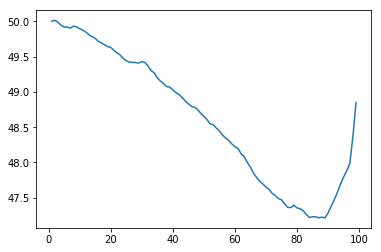

In [101]:
pyplot.show()

In [102]:
n_thres = x[y.index(max(y))]

In [104]:
y[0:10]

[49.9995,
 50.015,
 49.988,
 49.945,
 49.92,
 49.919,
 49.904,
 49.931,
 49.92,
 49.8955]

The variance between the min ad max values are very neglible and every time the random samples are generated, the accuracy is changing little bit. So, there is no particular threshold value which is best instead all are equally good 


In [96]:
## for method2
x, y = method(valid_1)

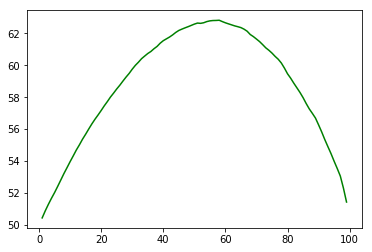

In [97]:
pyplot.plot(x, y, color ='g')
pyplot.show()

In [98]:
n_thres = x[y.index(max(y))]

In [99]:
print("n_thres :" + str(n_thres))
print("accuracy :" + str(max(y)))

n_thres :58
accuracy :62.813


For Method2 : the best threshold value is near 57-58 percentile

## Question3:
Users may tend to repeatedly visit business of the same type. Build a baseline that returns ‘True’ if
a user has visited a business of the same category before (at least one category in common), or zero
otherwise

In [14]:
data1 =[l for l in readGz("train.json.gz")]
train1 = data1[:len(data1)/2]

In [106]:
category_business ={}
category_user ={}

for d in train1:
    if d['businessID'] not in category_business:
        category_business[d['businessID']] = d['categories']
    else:
        category_business[d['businessID']].extend(d['categories'])
    if d['userID'] not in category_user:
        category_user[d['userID']] = d['categories']
    else:
        category_user[d['userID']].extend(d['categories'])

In [107]:

def acc(valid):
    true =0
    false =0

    for l in valid:
        u, i, label =l[0],l[1], l[2]
        if u in category_user :
            user = set(category_user[u])
        if i in category_business:
            business = set(category_business[i])
    
        common = set.intersection(user, business)

        if len(common) !=0 and label==1:
            true = true+1
        if len(common) == 0 and label==0:
            false = false+1
    
    accuracy = 100.0*(true+false)/len(valid)
    return accuracy

In [108]:
print ("%Accuracy on validation on Method1: " + str(acc(valid)))
print ("%Accuracy on validation on Method2: " + str(acc(valid_1)))

%Accuracy on validation on Method1: 56.436
%Accuracy on validation on Method2: 66.543


---
## Question4:
To run our model on the test set, we’ll have to use the files ‘pairs Visit.txt’ to find the userID/businessID
pairs about which we have to make predictions. Using that data, run the above model and upload your
solution to Kaggle

In [340]:
data1 =[l for l in readGz("train.json.gz")]

In [354]:
category_business = {}
category_user = {}

for d in data1:
    if d['businessID'] in category_business:
        category_business[d['businessID']].update(d['categories'])
    else:
        category_business[d['businessID']] = set()
        category_business[d['businessID']].update(d['categories'])
    
    if d['userID'] in category_user:
        category_user[d['userID']].update(d['categories'])
    else:
        category_user[d['userID']] = set()
        category_user[d['userID']].update(d['categories'])

In [406]:
predictions = open("predictions_Visit_mine.txt", 'w')
for l in open("pairs_Visit.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    
    u,i = l.strip().split('-')
    user = set()
    busi = set()
    if u in category_user :
        user = category_user[u]
    if i in category_business:
        business = category_business[i]
    
    common = set.intersection(user, business)
    #print( common)
    if len(common) !=0: 
        predictions.write(u + '-' + i + ",1\n")
    else:
        predictions.write(u + '-' + i + ",0\n")

predictions.close()

print("My Kaggle username is - 'Dragon' ")

My Kaggle username is - 'Dragon' 


---
# Rating Prediction
Let’s start by building our training/validation sets much as we did for the first task. This time building a
validation set is more straightforward, you can simply use half of the data for validation, and do not need to
randomly sample non-visited users/businesses.


## Question5:
What is the performance of a trivial predictor
<br>  rating(user, item) = α  
on the validation set, and what is the value of α?

In [167]:
import math

valid = data1[len(data1)/2:]
train = data1[:len(data1)/2]

count= 0
for d in train:
    count += d['rating']

alpha = count/len(train)
print ("alpha: " + str(alpha))

alpha: 4.18703


In [168]:
mse=0
for d in valid:
    mse += ((d['rating']- avg)**2)/len(valid) 

performance = 100.0*mse
print("Performance: " + str(performance))

Performance: 74.8343744499


---
## Question6:
Fit a predictor of the form
<br> rating(user, item) 'α + βuser + βitem,
by fitting the mean and the two bias terms as described in the lecture notes. Use a regularization
parameter of λ = 1. Report the MSE on the validation set


In [26]:
user = []
busi = []
count_u =[0]*18052
count_b =[0]*20490

for d in train1:
    if d['userID'] not in user:
        user.append(d['userID'])
    count_u[user.index(d['userID'])] +=1
        
    if d['businessID'] not in busi:
        busi.append(d['businessID'])
    count_b[busi.index(d['businessID'])] +=1
    
    
#user_map = {u : i for u,i in zip(user, range(len(user)))}
user_map = {u:i for i, u in enumerate(user)}
user_busi = {u:i for i, u in enumerate(busi)}

In [27]:
busi_map = user_busi

In [28]:
def loss_function(data, alpha, beta_u, beta_i,lam1,lam2, user_map, busi_map):
    f =0.0
    for x in data:
        u_index = user_map[x['userID']]
        b_index = busi_map[x['businessID']]
        f += (alpha + beta_u[u_index] + beta_i[b_index] - x['rating'])**2
    
    f += lam1*(sum(u*u for u in beta_u)) + lam2*(sum(b*b for b in beta_i))
    return f


def update_parameters(data, alpha, beta_u, beta_i,lam1, lam2, user_map, busi_map):
    alpha = 0
    for x in data:
        u_index = user_map[x['userID']]
        b_index = busi_map[x['businessID']]
        alpha += (1.0*(x['rating']- (beta_u[u_index] + beta_i[b_index])))/len(data)
        
    #print (loss_function(alpha, beta_u, beta_i,lam))
    
    beta_u  =[0.0]*len(beta_u)
    for x in data:
        u_index = user_map[x['userID']]
        b_index = busi_map[x['businessID']]
        beta_u[u_index] += (1.0*(x['rating'] - (alpha + beta_i[b_index])))/(lam1+ count_u[u_index])
        
    #print (loss_function(alpha, beta_u, beta_i,lam))
        
    beta_i = [0.0]*len(beta_i)
    for x in data:
        u_index = user_map[x['userID']]
        b_index = busi_map[x['businessID']]
        beta_i[b_index] += (1.0*(x['rating'] - (alpha + beta_u[u_index])))/(lam2+ count_b[b_index])
    
    #print (loss_function(alpha, beta_u, beta_i,lam))
    
    return alpha, beta_u, beta_i

In [79]:
alpha = 0.0
lam1 = 3.58
lam2 = 4.68
beta_u  =[0.0]*len(user)
beta_i = [0.0]*len(busi)
hst =[]

def converge(data, alpha, beta_u, beta_i, lam1,lam2, user_map, busi_map):
    
    tolerance = 1e-2
    loss =  loss_function(data, alpha, beta_u, beta_i,lam1,lam2, user_map, busi_map)
    hst.append(loss)
    loss = 0.0
    while (abs(hst[-1] - loss) > tolerance) :
        loss = hst[-1]
        alpha, beta_u, beta_i =  update_parameters(data, alpha, beta_u, beta_i,lam1, lam2, user_map, busi_map)
        #loss_function(data, alpha, beta_u, beta_i,lam))
        hst.append(loss_function(data, alpha, beta_u, beta_i,lam1, lam2, user_map, busi_map))
        print 10
    return alpha, beta_u, beta_i

In [80]:
f_alpha, f_beta_u, f_beta_i = converge(train1,alpha, beta_u, beta_i,lam1, lam2, user_map, busi_map)

10
10
10
10
10
10
10
10


In [64]:
import pickle

pickle.dump(hst, open("val_1","wb"))
pickle.dump(f_alpha, open("alpha","wb"))
pickle.dump(f_beta_u, open("beta_u","wb"))
pickle.dump(f_beta_i, open("beta_i","wb"))

In [81]:
valid = data1[len(data1)/2:]

def error_cal(data, f_alpha, f_beta_u, f_beta_i, user_map, busi_map):
    mse =0
    for d in valid:
        actual_val = d['rating']
    
        if d['userID'] in user and d['businessID'] in busi:
            pred_val = f_alpha + f_beta_u[user_map[d['userID']]] + f_beta_i[busi_map[d['businessID']]]
    
        elif d['userID'] not in user and d['businessID'] in busi:
            pred_val = f_alpha + f_beta_i[busi_map[d['businessID']]]
    
        elif d['businessID'] not in busi and d['userID'] in user:
            pred_val = f_alpha + f_beta_u[user_map[d['userID']]]
        
        else:
            pred_val = f_alpha
        
        mse += (pred_val - actual_val)**2

    return mse/len(data)

In [82]:
MSE = error_cal(valid, f_alpha, f_beta_u, f_beta_i, user_map, busi_map)
print("MSE: " + str(MSE))

MSE: 0.630184683661


## Question7:
Report the user and item IDs that have the largest and smallest values of β

In [174]:
min_userID = user[f_beta_u.index(min(f_beta_u))]
max_userID = user[f_beta_u.index(max(f_beta_u))]

min_itemID = busi[f_beta_i.index(min(f_beta_i))]
max_itemID = busi[f_beta_i.index(max(f_beta_i))]

print("user with largest beta: " + max_userID)
print("user with smallest beta: " + min_userID)
print("item with largest beta: " + max_itemID)
print("item with smallest beta: " + min_itemID)

user with largest beta: U357799541
user with smallest beta: U417838537
item with largest beta: B093985406
item with smallest beta: B241777680


## Question8:
Find a better value of λ using your validation set. Report the value you chose, its MSE, and upload your
solution to Kaggle by running it on the test data

In [218]:
for lam in range(1,11):
    f_alpha, f_beta_u, f_beta_i = converge(valid, alpha, beta_u, beta_i,lam)
    MSE = error_cal(valid, f_alpha, f_beta_u, f_beta_i)
    print("MSE: " + str(MSE[lam-1]) + " for lam :" + str(lam))

MSE: 0.645690752704 for lam :1
MSE: 0.617842608334 for lam :2
MSE: 0.609795238222 for lam :3
MSE: 0.607998533884 for lam :4
MSE: 0.608753372721 for lam :5
MSE: 0.610672442776 for lam :6
MSE: 0.613139006559 for lam :7
MSE: 0.615850309734 for lam :8
MSE: 0.618648639491 for lam :9
MSE: 0.621445834195 for lam :10


In [222]:
print ( "better lam = "+ str(4) + " and MSE: " + str(MSE[3]))

better lam = 4 and MSE: 0.607998533884


In [74]:
user = []
busi = []
count_u =[0]*18793
count_b =[0]*21321

for d in data1:
    if d['userID'] not in user:
        user.append(d['userID'])
    count_u[user.index(d['userID'])] +=1
        
    if d['businessID'] not in busi:
        busi.append(d['businessID'])
    count_b[busi.index(d['businessID'])] +=1
    
user_map = {u:i for i, u in enumerate(user)}
user_busi = {u:i for i, u in enumerate(busi)}

In [75]:
busi_map = user_busi

In [76]:
alpha = 0.0
lam1 = 4
lam2 = 4.7
beta_u  =[0.0]*len(user)
beta_i = [0.0]*len(busi)
hst =[]

f_alpha, f_beta_u, f_beta_i = converge(data1, alpha, beta_u, beta_i,lam1, lam2, user_map, busi_map)

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


In [246]:
pickle.dump(hst, open("val_2","wb"))
pickle.dump(f_alpha, open("alpha_2","wb"))
pickle.dump(f_beta_u, open("beta_u2","wb"))
pickle.dump(f_beta_i, open("beta_i2","wb"))

In [78]:
predictions = open("predictions_Rating_mine_lam.txt", 'w')

for l in open("pairs_Rating.txt"):
    if l.startswith("userID"):
    #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')
    
    if u in user and i in busi:
        pred_val = f_alpha + f_beta_u[user.index(u)] + f_beta_i[busi.index(i)]
        if pred_val > 5:
            pred_val = 5
        if pred_val <0:
            pred_val = 0
        
        predictions.write(u + '-' + i + ',' + str(pred_val) + '\n')
    
    elif u not in user and i in busi:
        pred_val = f_alpha + f_beta_i[busi.index(i)]
        if pred_val > 5:
            pred_val = 5
        if pred_val <0:
            pred_val = 0
        
        predictions.write(u + '-' + i + ',' + str(pred_val) + '\n')
    
    elif i not in busi and u in user:
        pred_val = f_alpha + f_beta_u[user.index(u)]
        if pred_val > 5:
            pred_val = 5
        if pred_val <0:
            pred_val = 0
        
        predictions.write(u + '-' + i + ',' + str(pred_val) + '\n')

    else:
        pred_val = f_alpha
        if pred_val > 5:
            pred_val = 5
        if pred_val <0:
            pred_val = 0
        
        predictions.write(u + '-' + i + ',' + str(pred_val) + '\n')

predictions.close()
